In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [95]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.7
fontColor              = (255,0,0)
thickness              = 2
lineType               = 2

In [76]:
def binarize_stripes(stripes_raw, verbose=False):
    stripes_gray = cv2.cvtColor(stripes_raw, cv2.COLOR_BGR2GRAY)
    stripes_blured = cv2.GaussianBlur(stripes_gray, (5, 5), 0)
    _, stripes_binarized = cv2.threshold(stripes_blured, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    if verbose:
        plt.imshow(stripes_binarized, 'grey')
        plt.show()
    return stripes_binarized

In [77]:
def find_n_contours(stripes_binarized, stripes_raw, n, verbose=False):
    contours, _ = cv2.findContours(stripes_binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_sorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    if verbose:
        stripes_raw_copy = deepcopy(stripes_raw)
        stripes_raw_copy = cv2.cvtColor(stripes_raw_copy, cv2.COLOR_BGR2RGB)
        rectangle_size = 20
        for contour in contours_sorted[:n]:
            M = cv2.moments(contour)
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            cv2.drawContours(stripes_raw_copy, [contour], -1, (200, 0, 0), 2)
            cv2.circle(stripes_raw_copy, (cx, cy), 5, (0, 160, 0), -1)
            cv2.rectangle(stripes_raw_copy, (cx-rectangle_size, cy-rectangle_size), (cx+rectangle_size, cy+rectangle_size), (0, 0, 160))

        plt.imshow(stripes_raw_copy)
        plt.show()
    return contours_sorted[:n]

In [ ]:
def match_contours_to_calibration(calibration_dict, stripes_raw, contours):
    valued_contours = []
    for contour in contours:
        M = cv2.moments(contour)
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        value = np.mean(stripes_raw[cy-10: cy+10, cx-10: cx+10])
        valued_contours.append((contour, value))
    valued_contours = sorted(valued_contours, key=lambda x: x[1], reverse=True)
    
    contours_matched = {id: {"value": calibration_dict[id], "contour": valued_contour[0]} for id, valued_contour in zip(calibration_dict.keys(), valued_contours)}
    return contours_matched

In [123]:
def find_centers_of_dark_areas(contours_matched, stripes_raw):
    control_stripe_contour = contours_matched[0]['contour']
    control_stripe_M = cv2.moments(control_stripe_contour)
    control_stripe_cx = int(control_stripe_M["m10"] / control_stripe_M["m00"])
    control_stripe_cy = int(control_stripe_M["m01"] / control_stripe_M["m00"])
    contours_matched[0]['cx'] = control_stripe_cx
    contours_matched[0]['cy'] = control_stripe_cy

    fill_value = int(np.mean(stripes_raw[control_stripe_cy-10: control_stripe_cy+10, control_stripe_cx-10: control_stripe_cx+10]))

    for contour_id in contours_matched.keys():
        if contour_id == 0:
            continue
        contour = contours_matched[contour_id]['contour']

        stripe_gray = cv2.cvtColor(stripes_raw, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(stripe_gray)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        stripe_masked = cv2.bitwise_and(stripe_gray, stripe_gray, mask=mask)
        stripe_masked[stripe_masked == 0] = fill_value
        
        _, stripe_darker = cv2.threshold(stripe_masked, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
        darker_contours, _ = cv2.findContours(stripe_darker, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        darker_contours = sorted(darker_contours, reverse=True, key=lambda x: cv2.contourArea(x))
        dark_contour = darker_contours[0]
        
        M = cv2.moments(dark_contour)
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        contours_matched[contour_id]['cx'] = cx
        contours_matched[contour_id]['cy'] = cy
    return contours_matched

In [124]:
def prepare_output(contours_matched):
    return {id: {'x': contour_info['cx'], 'y': contour_info['cy'], 'value': contour_info['value']} for id, contour_info in contours_matched.items()}

In [125]:
def plot_matched_dict(stripes_raw, contours_matched, centers_from_dict=False):
    stripes_raw_copy = deepcopy(stripes_raw)
    stripes_raw_copy = cv2.cvtColor(stripes_raw_copy, cv2.COLOR_BGR2RGB)

    for contour_id in contours_matched.keys():
        contour = contours_matched[contour_id]['contour']
        if centers_from_dict:
            cx = contours_matched[contour_id]['cx']
            cy = contours_matched[contour_id]['cy']
        else:
            M = cv2.moments(contour)
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        
        cv2.drawContours(stripes_raw_copy, [contour], -1, (200, 0, 0), 2)
        cv2.circle(stripes_raw_copy, (cx, cy), 5, (0, 160, 0), -1)
        rectangle_size = 20
        cv2.rectangle(stripes_raw_copy, (cx-rectangle_size, cy-rectangle_size), (cx+rectangle_size, cy+rectangle_size), (0, 0, 160))
        cv2.putText(stripes_raw_copy, f"{contours_matched[contour_id]['value']}", (cx-20, cy-30), font, fontScale, fontColor, thickness, lineType)
    plt.imshow(stripes_raw_copy)
    plt.show()

In [129]:
def markers_detection(stripes_bgr, calibration_lines):
    calibration_dict = {int(el[0].strip()): int(el[1].strip()) for el in [line.split('-') for line in calibration_lines]}
    
    stripes_binarized = binarize_stripes(stripes_bgr, False)

    contours = find_n_contours(stripes_binarized, stripes_bgr, len(calibration_dict), False)

    contours_matched = match_contours_to_calibration(calibration_dict, stripes_bgr, contours)

    contours_matched = find_centers_of_dark_areas(contours_matched, stripes_bgr)
    output = prepare_output(contours_matched)
    return output

In [128]:
stripes_raw = cv2.imread('C:\Studia\Magisterka\dosymetry_slicer\X6 MV FFF Kalibracja 2023.07.31.png', cv2.IMREAD_COLOR)
with open('C:\Studia\Magisterka\dosymetry_slicer\Dawki_kalibracja.txt', 'r') as f:
    calibration_lines = [line.strip() for line in f.readlines() if line.strip() != '']
markers_detection(stripes_raw, calibration_lines)

{0: {'x': 65, 'y': 327, 'value': 0},
 3: {'x': 145, 'y': 323, 'value': 298},
 6: {'x': 236, 'y': 322, 'value': 596},
 9: {'x': 322, 'y': 312, 'value': 894},
 12: {'x': 410, 'y': 321, 'value': 1192},
 15: {'x': 504, 'y': 335, 'value': 1490},
 18: {'x': 600, 'y': 337, 'value': 1788},
 21: {'x': 689, 'y': 343, 'value': 2086},
 24: {'x': 783, 'y': 335, 'value': 2384},
 27: {'x': 876, 'y': 330, 'value': 2681}}

{0: 0, 3: 298, 6: 596, 9: 894, 12: 1192, 15: 1490, 18: 1788, 21: 2086, 24: 2384, 27: 2681}


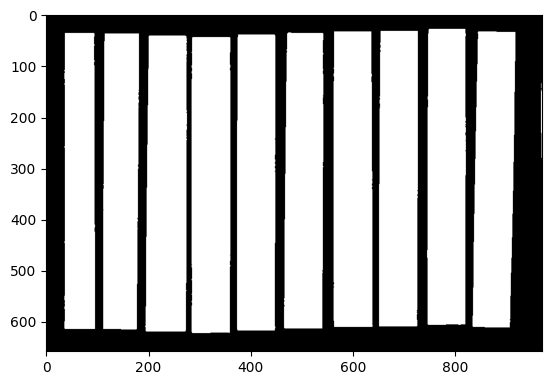

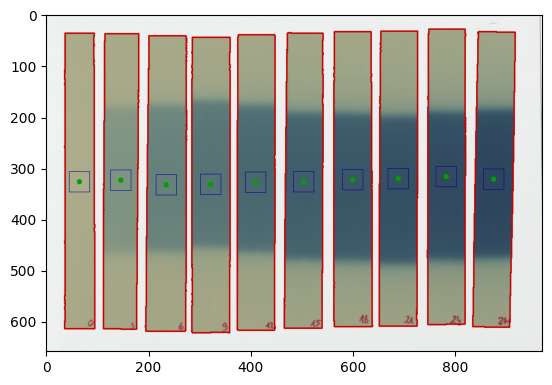

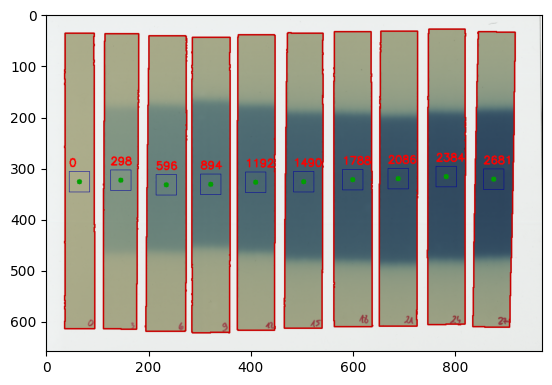

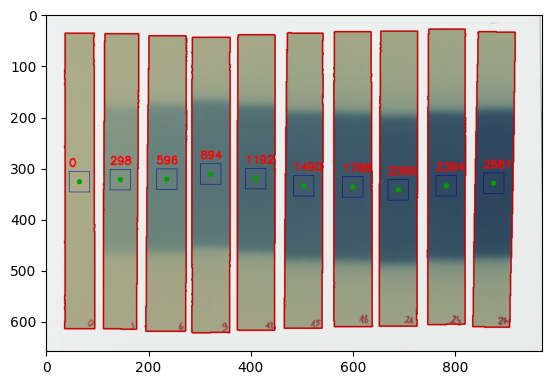

{0: {'x': 65, 'y': 327, 'value': 0}, 3: {'x': 145, 'y': 323, 'value': 298}, 6: {'x': 236, 'y': 322, 'value': 596}, 9: {'x': 322, 'y': 312, 'value': 894}, 12: {'x': 410, 'y': 321, 'value': 1192}, 15: {'x': 504, 'y': 335, 'value': 1490}, 18: {'x': 600, 'y': 337, 'value': 1788}, 21: {'x': 689, 'y': 343, 'value': 2086}, 24: {'x': 783, 'y': 335, 'value': 2384}, 27: {'x': 876, 'y': 330, 'value': 2681}}


In [ ]:
stripes_raw = cv2.imread('C:\Studia\Magisterka\dosymetry_slicer\X6 MV FFF Kalibracja 2023.07.31.png', cv2.IMREAD_COLOR)
with open('C:\Studia\Magisterka\dosymetry_slicer\Dawki_kalibracja.txt', 'r') as f:
    calibration_lines = [line.strip() for line in f.readlines() if line.strip() != '']
    
calibration_dict = {int(el[0].strip()): int(el[1].strip()) for el in [line.split('-') for line in calibration_lines]}
print(calibration_dict)

stripes_binarized = binarize_stripes(stripes_raw, True)

contours = find_n_contours(stripes_binarized, stripes_raw, len(calibration_dict), True)

contours_matched = match_contours_to_calibration(calibration_dict, stripes_raw, contours)
plot_matched_dict(stripes_raw, contours_matched)

contours_matched = find_centers_of_dark_areas(contours_matched, stripes_raw)
plot_matched_dict(stripes_raw, contours_matched, centers_from_dict=True)
output = prepare_output(contours_matched)
print(output)